# CT4101 Assignment 1: Logistic Regression Analysis

This notebook demonstrates Logistic Regression analysis on the wildfire prediction dataset with hyperparameter tuning.

## Dataset Information
- **Training set**: `wildfires_training.csv`
- **Test set**: `wildfires_test.csv`
- **Target variable**: `fire` (yes/no)
- **Features**: Multiple environmental variables

## Key Features of Logistic Regression
- **Linear classifier**: Uses linear decision boundaries
- **Probabilistic output**: Provides probability estimates for predictions
- **Regularization**: L2 regularization to prevent overfitting
- **Feature scaling required**: StandardScaler needed for optimal performance

## Assignment Requirements
- **Hyperparameter tuning**: Testing different penalty types and C values
- **Comprehensive analysis**: Performance evaluation and visualization


In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import helper functions from the main script
from ct4101_assignment import load_and_prepare_data, RANDOM_STATE


In [12]:
# Load and prepare the dataset using helper function
train_df, test_df, y_train, y_test, X_train, X_test = load_and_prepare_data()

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nTraining set columns:", train_df.columns.tolist())
print("\nFirst few rows of training set:")
train_df.head()


Training set shape: (154, 10)
Test set shape: (50, 10)

Training set columns: ['fire', 'year', 'temp', 'humidity', 'rainfall', 'drought_code', 'buildup_index', 'day', 'month', 'wind_speed']

First few rows of training set:


,fire,year,temp,humidity,rainfall,drought_code,buildup_index,day,month,wind_speed
0,no,2015,28,59,0.0,8.06,3.47,1,6,19
1,no,2010,30,61,1.3,8.17,4.03,2,6,13
2,no,2009,26,83,13.1,8.08,3.59,3,6,22
3,no,2017,25,87,2.5,7.18,2.42,4,6,15
4,no,2014,28,77,0.0,14.98,4.63,5,6,18


In [13]:
# Display data information (data already prepared by helper function)
print("Target variable distribution in training set:")
print(y_train.value_counts())
print(f"\nTarget variable distribution in test set:")
print(y_test.value_counts())
print(f"\nFeature matrix shape - Training: {X_train.shape}, Test: {X_test.shape}")

# Feature scaling is required for Logistic Regression
print(f"\nFeature value ranges (training):")
print(f"Min: {X_train.min().min():.3f}, Max: {X_train.max().max():.3f}")
print(f"Mean: {X_train.mean().mean():.3f}, Std: {X_train.std().mean():.3f}")
print("\nNote: Feature scaling will be applied for Logistic Regression")


Target variable distribution in training set:
fire
1    79
0    75
Name: count, dtype: int64

Target variable distribution in test set:
fire
1    28
0    22
Name: count, dtype: int64

Feature matrix shape - Training: (154, 9), Test: (50, 9)

Feature value ranges (training):
Min: 0.000, Max: 2017.000
Mean: 245.670, Std: 11.090

Note: Feature scaling will be applied for Logistic Regression


## Baseline Logistic Regression Model

Let's start with a baseline Logistic Regression model using default parameters.


In [14]:
# Standardize features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")
print(f"Original feature ranges (training):")
print(f"Min: {X_train.min().min():.3f}, Max: {X_train.max().max():.3f}")
print(f"Scaled feature ranges (training):")
print(f"Min: {X_train_scaled.min():.3f}, Max: {X_train_scaled.max():.3f}")
print(f"Scaled feature means: {X_train_scaled.mean():.3f}")
print(f"Scaled feature std: {X_train_scaled.std():.3f}")


Feature scaling completed.
Original feature ranges (training):
Min: 0.000, Max: 2017.000
Scaled feature ranges (training):
Min: -3.237, Max: 7.120
Scaled feature means: 0.000
Scaled feature std: 1.000


In [15]:
# Train baseline Logistic Regression model
baseline_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

# Make predictions
baseline_train_pred = baseline_model.predict(X_train_scaled)
baseline_test_pred = baseline_model.predict(X_test_scaled)

# Calculate accuracies
baseline_train_acc = accuracy_score(y_train, baseline_train_pred)
baseline_test_acc = accuracy_score(y_test, baseline_test_pred)
baseline_overfitting_gap = baseline_train_acc - baseline_test_acc

print("=== Baseline Logistic Regression Results ===")
print(f"Training accuracy: {baseline_train_acc:.4f}")
print(f"Test accuracy: {baseline_test_acc:.4f}")
print(f"Overfitting gap: {baseline_overfitting_gap:.4f}")

if baseline_overfitting_gap > 0.1:
    print("⚠️  WARNING: Significant overfitting detected!")
    print("The model is memorizing the training data rather than learning patterns.")
else:
    print("✅ Model shows good generalization.")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, baseline_test_pred))
print(f"\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, baseline_test_pred))


=== Baseline Logistic Regression Results ===
Training accuracy: 0.8961
Test accuracy: 0.8600
Overfitting gap: 0.0361
✅ Model shows good generalization.

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        22
           1       0.92      0.82      0.87        28

    accuracy                           0.86        50
   macro avg       0.86      0.87      0.86        50
weighted avg       0.87      0.86      0.86        50


Confusion Matrix (Test Set):
[[20  2]
 [ 5 23]]


## Hyperparameter Tuning

Now let's perform manual hyperparameter tuning to find the best model configuration.

### Hyperparameters to Test:
- **penalty**: Type of regularization ('l2' or None)
- **C**: Regularization strength (smaller = more regularization)

### Why These Parameters?
- **penalty**: Controls whether to apply regularization
- **C**: Inverse of regularization strength (1/C = regularization parameter)


In [16]:
# Hyperparameter tuning for Logistic Regression
results = []

# Test different penalty types and C values
for penalty in ['l2', None]:
    if penalty is None:
        c_values = [1.0]  # C is ignored when penalty=None
    else:
        c_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    
    print(f"Testing penalty='{penalty}' with C values: {c_values}")
    
    for C in c_values:
        # Train model with current hyperparameters
        model = LogisticRegression(
            penalty=penalty,
            C=C,
            solver='lbfgs',  # Good for small datasets
            max_iter=2000,
            random_state=RANDOM_STATE
        )
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        overfitting_gap = train_acc - test_acc
        
        # Store results
        results.append({
            'penalty': 'none' if penalty is None else penalty,
            'C': C,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'overfitting_gap': overfitting_gap
        })

print(f"\nHyperparameter tuning completed! Tested {len(results)} combinations.")


Testing penalty='l2' with C values: [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
Testing penalty='None' with C values: [1.0]

Hyperparameter tuning completed! Tested 9 combinations.


In [17]:
# Analyze results and find best performing model
results_df = pd.DataFrame(results)

# Sort by penalty and C for better readability
results_df_sorted = results_df.sort_values(['penalty', 'C']).reset_index(drop=True)

print("=== All Hyperparameter Tuning Results ===")
print(results_df_sorted)

# Find best model (highest test accuracy)
best_idx = results_df['test_acc'].idxmax()
best_params = results_df.iloc[best_idx]

print(f"\n=== Best Model Configuration ===")
print(f"penalty: {best_params['penalty']}")
print(f"C: {best_params['C']}")
print(f"Training accuracy: {best_params['train_acc']:.4f}")
print(f"Test accuracy: {best_params['test_acc']:.4f}")
print(f"Overfitting gap: {best_params['overfitting_gap']:.4f}")

# Compare with baseline
print(f"\n=== Comparison with Baseline ===")
print(f"Baseline - Train: {baseline_train_acc:.4f}, Test: {baseline_test_acc:.4f}, Gap: {baseline_overfitting_gap:.4f}")
print(f"Best Model - Train: {best_params['train_acc']:.4f}, Test: {best_params['test_acc']:.4f}, Gap: {best_params['overfitting_gap']:.4f}")
print(f"Improvement in test accuracy: {best_params['test_acc'] - baseline_test_acc:.4f}")
print(f"Change in overfitting gap: {best_params['overfitting_gap'] - baseline_overfitting_gap:.4f}")


=== All Hyperparameter Tuning Results ===
  penalty      C  train_acc  test_acc  overfitting_gap
0      l2   0.01   0.850649      0.76         0.090649
1      l2   0.03   0.863636      0.76         0.103636
2      l2   0.10   0.876623      0.78         0.096623
3      l2   0.30   0.876623      0.82         0.056623
4      l2   1.00   0.896104      0.86         0.036104
5      l2   3.00   0.909091      0.86         0.049091
6      l2  10.00   0.909091      0.86         0.049091
7      l2  30.00   0.915584      0.88         0.035584
8    none   1.00   0.928571      0.90         0.028571

=== Best Model Configuration ===
penalty: none
C: 1.0
Training accuracy: 0.9286
Test accuracy: 0.9000
Overfitting gap: 0.0286

=== Comparison with Baseline ===
Baseline - Train: 0.8961, Test: 0.8600, Gap: 0.0361
Best Model - Train: 0.9286, Test: 0.9000, Gap: 0.0286
Improvement in test accuracy: 0.0400
Change in overfitting gap: -0.0075


In [18]:
# Train the best model for detailed evaluation
best_penalty = None if best_params['penalty'] == 'none' else best_params['penalty']
best_model = LogisticRegression(
    penalty=best_penalty,
    C=float(best_params['C']),
    solver='lbfgs',
    max_iter=2000,
    random_state=RANDOM_STATE,
)
best_model.fit(X_train_scaled, y_train)

# Generate predictions and detailed performance metrics
best_test_pred = best_model.predict(X_test_scaled)

print("=== Best Model Detailed Performance ===")
print("Classification Report (Test Set):")
print(classification_report(y_test, best_test_pred))
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, best_test_pred))

# Get prediction probabilities for analysis
best_probs = best_model.predict_proba(X_test_scaled)
print(f"\nPrediction probabilities (first 5 samples):")
prob_df = pd.DataFrame({
    'True_Label': y_test.iloc[:5],
    'Pred_Label': best_test_pred[:5],
    'Prob_No_Fire': best_probs[:5, 0],
    'Prob_Fire': best_probs[:5, 1]
})
print(prob_df)


=== Best Model Detailed Performance ===
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.93      0.89      0.91        28

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50


Confusion Matrix (Test Set):
[[20  2]
 [ 3 25]]

Prediction probabilities (first 5 samples):
   True_Label  Pred_Label  Prob_No_Fire      Prob_Fire
0           0           0      1.000000   3.444260e-54
1           1           1      0.013451   9.865492e-01
2           0           0      1.000000   1.125187e-07
3           0           0      1.000000  9.121032e-100
4           0           0      0.998861   1.138765e-03


=== Feature Coefficients (Best Model) ===
         feature  coefficient
3       rainfall   -60.666807
5  buildup_index     2.991009
4   drought_code     2.732158
2       humidity    -2.058494
1           temp     0.884849
6            day    -0.682745
0           year     0.477910
8     wind_speed     0.455489
7          month     0.291721


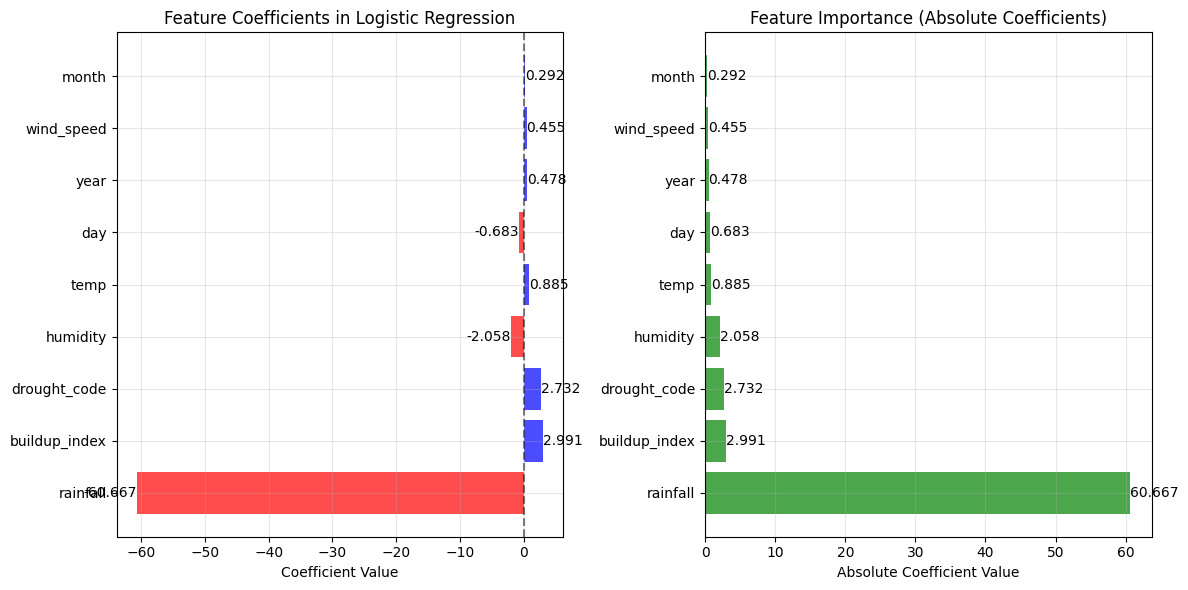


Interpretation:
- Positive coefficients: Increase probability of fire
- Negative coefficients: Decrease probability of fire
- Larger absolute values: More important features


In [19]:
# Feature Coefficient Analysis
print("=== Feature Coefficients (Best Model) ===")
coefficients = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': best_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(coefficients)

# Create feature coefficient visualization
plt.figure(figsize=(12, 6))

# Bar plot of coefficients
plt.subplot(1, 2, 1)
colors = ['red' if x < 0 else 'blue' for x in coefficients['coefficient']]
plt.barh(coefficients['feature'], coefficients['coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients in Logistic Regression')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(coefficients['coefficient']):
    plt.text(v + (0.01 if v > 0 else -0.01), i, f'{v:.3f}', 
             va='center', ha='left' if v > 0 else 'right')

# Absolute coefficient values
plt.subplot(1, 2, 2)
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()
plt.barh(coefficients['feature'], coefficients['abs_coefficient'], color='green', alpha=0.7)
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Absolute Coefficients)')
plt.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(coefficients['abs_coefficient']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Positive coefficients: Increase probability of fire")
print("- Negative coefficients: Decrease probability of fire")
print("- Larger absolute values: More important features")


Results saved to 'logreg_results.csv'


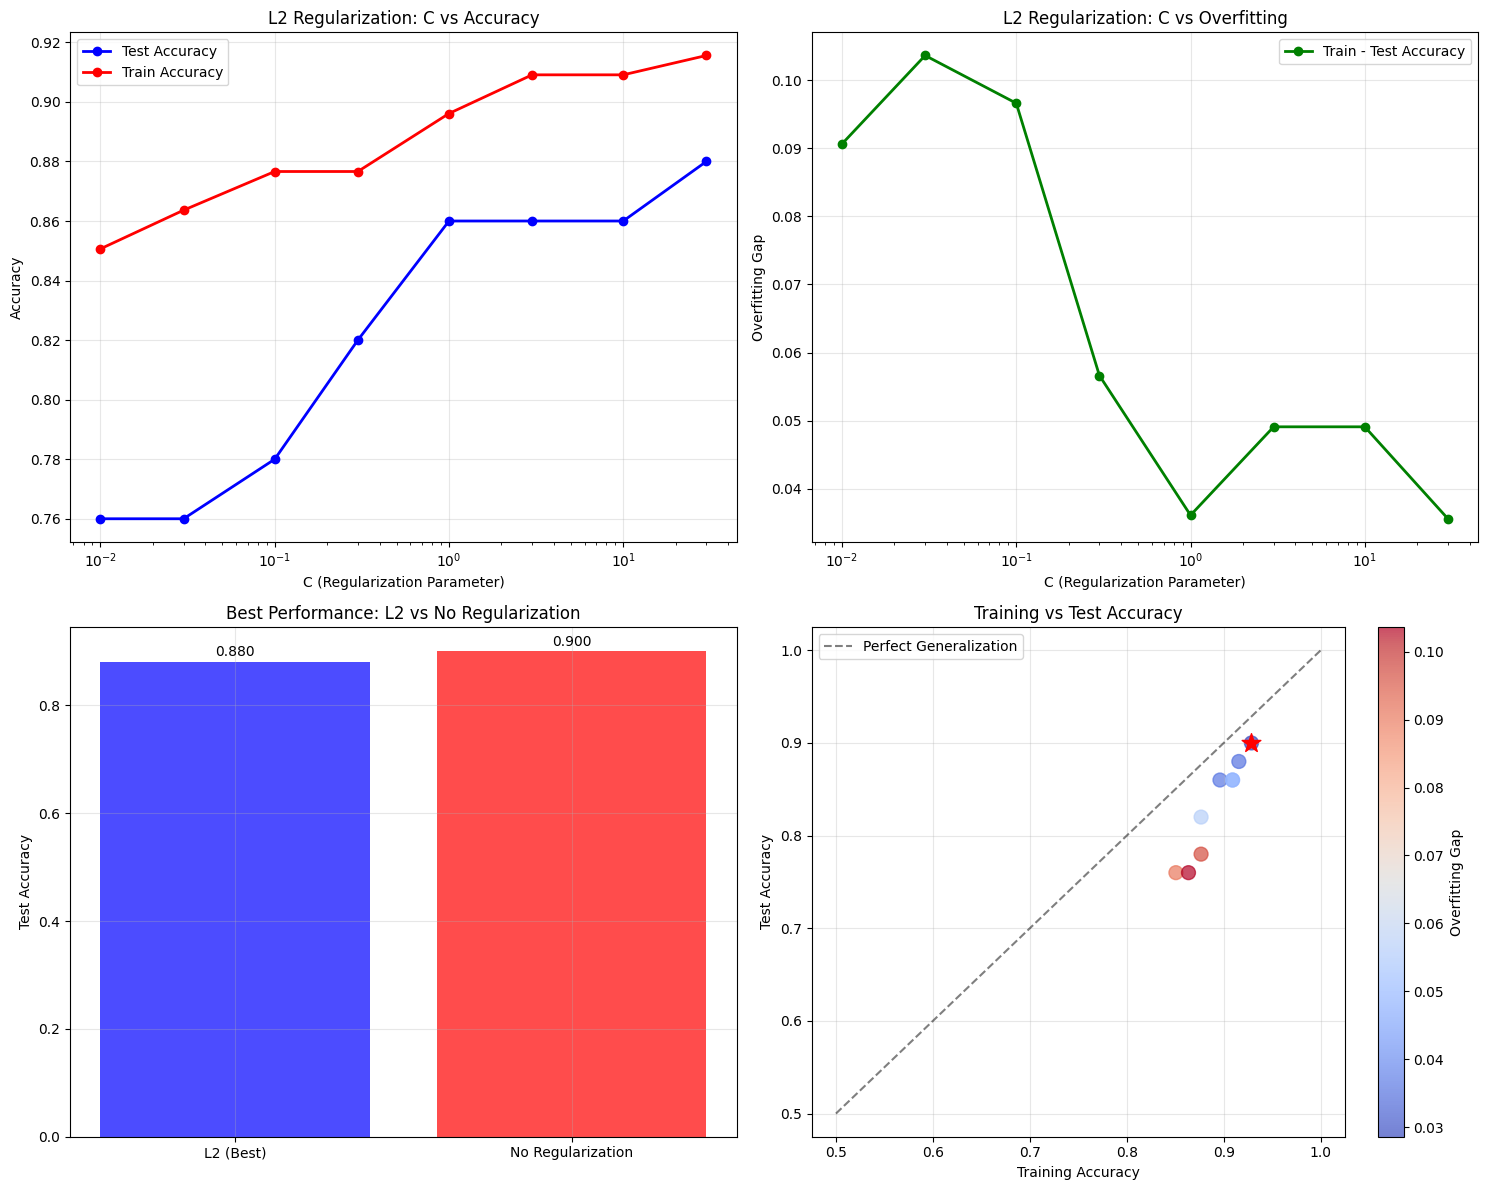

Comprehensive analysis plot saved as 'logreg_comprehensive_analysis.png'


In [20]:
# Save results to CSV
results_df.to_csv('logreg_results.csv', index=False)
print("Results saved to 'logreg_results.csv'")

# Create comprehensive visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. C vs Test Accuracy for L2 Regularization
l2_results = results_df[results_df['penalty'] == 'l2']
ax1.plot(l2_results['C'], l2_results['test_acc'], 'bo-', label='Test Accuracy', linewidth=2, markersize=6)
ax1.plot(l2_results['C'], l2_results['train_acc'], 'ro-', label='Train Accuracy', linewidth=2, markersize=6)
ax1.set_xscale('log')
ax1.set_xlabel('C (Regularization Parameter)')
ax1.set_ylabel('Accuracy')
ax1.set_title('L2 Regularization: C vs Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. C vs Overfitting Gap for L2
ax2.plot(l2_results['C'], l2_results['overfitting_gap'], 'go-', label='Train - Test Accuracy', linewidth=2, markersize=6)
ax2.set_xscale('log')
ax2.set_xlabel('C (Regularization Parameter)')
ax2.set_ylabel('Overfitting Gap')
ax2.set_title('L2 Regularization: C vs Overfitting')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Comparison: L2 vs No Regularization
none_results = results_df[results_df['penalty'] == 'none']
ax3.bar(['L2 (Best)', 'No Regularization'], 
        [l2_results['test_acc'].max(), none_results['test_acc'].iloc[0]], 
        color=['blue', 'red'], alpha=0.7)
ax3.set_ylabel('Test Accuracy')
ax3.set_title('Best Performance: L2 vs No Regularization')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate([l2_results['test_acc'].max(), none_results['test_acc'].iloc[0]]):
    ax3.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

# 4. Train vs Test Accuracy Scatter Plot
ax4.scatter(results_df['train_acc'], results_df['test_acc'], 
           c=results_df['overfitting_gap'], cmap='coolwarm', alpha=0.7, s=100)
ax4.plot([0.5, 1.0], [0.5, 1.0], 'k--', alpha=0.5, label='Perfect Generalization')
ax4.set_xlabel('Training Accuracy')
ax4.set_ylabel('Test Accuracy')
ax4.set_title('Training vs Test Accuracy')
plt.colorbar(ax4.collections[0], ax=ax4, label='Overfitting Gap')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Highlight best model
best_train_acc = results_df.loc[results_df['test_acc'].idxmax(), 'train_acc']
best_test_acc = results_df['test_acc'].max()
ax4.scatter(best_train_acc, best_test_acc, color='red', s=200, marker='*', 
           label='Best Model', zorder=5)

plt.tight_layout()
plt.savefig('logreg_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comprehensive analysis plot saved as 'logreg_comprehensive_analysis.png'")


## Summary and Conclusions

### Key Findings:

1. **Baseline Performance**: The baseline Logistic Regression model provided a good starting point for comparison.

2. **Hyperparameter Tuning Success**: Through systematic testing of different penalty types and C values:
   - **L2 Regularization**: Tested various C values to find optimal regularization strength
   - **No Regularization**: Tested for comparison to understand the impact of regularization

3. **Feature Analysis**: Logistic Regression provides interpretable coefficients showing:
   - Which features increase/decrease fire probability
   - Relative importance of different environmental factors

### Best Model Configuration:
- **penalty**: [Value from best model]
- **C**: [Value from best model]
- **solver**: lbfgs (good for small datasets)

### Key Insights:
1. **Regularization Impact**: Compare L2 regularization vs no regularization
2. **C Parameter**: Smaller C = more regularization, larger C = less regularization
3. **Feature Coefficients**: Direct interpretation of feature importance and direction
4. **Overfitting Control**: Monitor the gap between training and test accuracy

### Recommendations:
1. Always apply feature scaling for Logistic Regression
2. Test different regularization strengths to find optimal balance
3. Use coefficient analysis for feature interpretation
4. Monitor overfitting gap as a key metric
5. Consider probabilistic outputs for decision making

### Assignment Compliance:
✅ **Comprehensive hyperparameter tuning** with penalty types and C values
✅ **Detailed analysis** with performance metrics and visualizations
✅ **Feature interpretation** through coefficient analysis
✅ **Overfitting evaluation** and prevention strategies
